# Homework 4

Eugenio Baldo, Giovanni Giunta and  Leonardo Masci - Group 22

# Question 1

The goal of this first exercise was to gain an understanding of hashing and the HyperLogLog algorithm, the state of the art when it comes to estimating the number of unique users.
In order to accomplish this task we have consulted a number of resources, including the following paper ( http://algo.inria.fr/flajolet/Publications/FlFuGaMe07.pdf ) from which we got a lot of the formulas we then implemented in our HLL function.

Our work for this exercise is articulated in three steps:
1. Transform the given dataset into a set of binaries
2. Implement our HLL function
3. Estimate the number of unique elements

### Creating the binary file

First of all, we import everything we need and visualise the given initial txt file.

In [20]:
import pandas as pd
import functions as mod
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import TruncatedSVD as SVD
from wordcloud import WordCloud as WC
from PIL import Image
from sklearn.cluster import KMeans
import itertools
import json
import math

In [2]:
dataset = pd.read_csv('hash.txt', header=None)

dataset.head()

,0
0,844082e02a27ddee8d99ea1af94a2969
1,ff96d6665b5c59d3a70bb8f2ba4f10be
2,b64a85884e2b159829331c19e05dbac9
3,1c8836719e84867c26ba2cfeb372c53d
4,b66f73ffd9008d9c99159e164261df51


The dataset is comprised of hexadecimal numbers. Therefore, in order to create our binary file we simply had to convert those numbers into binaries. A problem we encountered with this step was that not all the output values were of the same length, which created problems in the following steps. For this reason, we decided to add 0s as needed to reach the desired length for each binary value. We included the results in a txt file to avoid having to recreate the dataset every time.

In [63]:
f = open("binaries.txt", "w")

for i, row in dataset.iterrows():            
    bin_value = bin(int(row[0], 16))[2:].zfill(len(row[0]) * 4)
    f.write(bin_value + '\n')

    if (i % 10000000) == 0:
        print(i)

f.close()

In [3]:
binaries = pd.read_csv('binaries.txt', header=None)

binaries.head()

,0
0,1000010001000000100000101110000000101010001001...
1,1111111110010110110101100110011001011011010111...
2,1011011001001010100001011000100001001110001010...
3,0001110010001000001101100111000110011110100001...
4,1011011001101111011100111111111111011001000000...


### Implementing our HyperLogLog function

Given the size of the binaries and the amount of values we were working with, we decided that 16 would be a good number of bytes to determine the destination bucket of each value, as we would end up with ${2^{16}}$ buckets. We also initialised a dictionary that had 0 as the value for every single bucket.

We then counted the number of 0s found in each string binary value until the first 1 was encountered. Lastly, we confronted this number with the number already present for the corresponding bucket: if the new value was higher we substituted it. This way we ended up with a dictionary containing the highest amount of consecutive 0s for each bucket.

In [57]:
b = 16
values = [int("".join(map(str, list(i))), 2) for i in itertools.product([0, 1], repeat=b)]
db = {x: 0 for x in values}

def hyperLogLog(binary, b):
    bucket = int(binary[:b], 2)
    rest = binary[b:]
    count = 0
    for char in rest:
        if char == '0':
            count += 1
        else:
            count += 1
            break

    if db[bucket] < count:
        db[bucket] = count

    if (i % 10000000) == 0:
        print(i)

Once the function was ready, we applied it to our binary dataset and saved the resulting dictionary as a json file, again for easy future access.

In [4]:
for i, row in binaries.iterrows():
    binary = row[0]
    hyperLogLog(binary, b)


In [90]:
with open("db.json", "w") as outfile: 
    json.dump(db, outfile, indent = 4)

In [5]:
with open('db.json') as f:
    dt = json.load(f)

### Estimating amount of unique elements

Using the formulas we found in the above mentioned paper, we calculated the following values based on our final dictionary.

In [6]:
def calc_z(values):
    z = 0
    for x in values:
        z += 2 ** (-x)
    return z

m = len(dt)
values = list(dt.values())
z = calc_z(values)
alpha = 0.7213/(1 + 1.079 / m )
E = round((alpha * float(m**2)) / z)
error = 1.04 / (math.sqrt(m))

In [7]:
E

125674524

In [8]:
error

0.0040625

In conclusion, we estimated that the cardinality of our initial dataset was of about 125 million, with an approximated error of 0.004.

# Question 2

In this second exercise we were asked to cluster given products (fine foods) bought on Amazon, based on their reviews. In order to do this we had to implement our own clustering algorithm, apply it to the provided dataset and analyse the resulting clusters.

### Importing and cleaning the dataset

Before moving on to implementing our function, it was necessary to carefully analyse the dataset we would be working with and clean it as needed. For the first exercise we started by importing everything we need and visualising the dataset.

In [2]:
df1 = pd.read_csv("Reviews.csv", header="infer")

df1.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [3]:
df1["ProfileName"].fillna("",inplace=True)
df1["Summary"].fillna('',inplace=True)
df1.set_index("Id", inplace=True)
df1['Datetime'] = df1.Time.apply(lambda value: pd.to_datetime(value, unit='s'))

In the following section, NLTK was used to process the plain review texts, which we then added to a column based on the tokens of the dataset.

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\giogi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\giogi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\giogi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
stop_words = set(stopwords.words('english'))
wordlist_1 = df1["Text"].apply(lambda text: mod.new_text(text,stop_words)).to_list()
df1["taken_words"] = wordlist_1

df1.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime,taken_words
Id,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,"[bought, several, vitality, canned, dog, food,..."
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,"[product, arrived, labeled, jumbo, salted, pea..."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,"[confection, around, century, light, pillowy, ..."
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,"[looking, secret, ingredient, robitussin, beli..."
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,"[great, taffy, great, price, wide, assortment,..."


Our idea was to cluster the review texts by only taking into account the adjectives. We arrived at this conclusion after considering the role played by adjectives in a sentence, since the use of a specific combination of adjectives denotes the overall connotation of the text. We decided to use only the 1000 most popular adjectives found in the reviews as dimensions of our analysis. This allowed us to only take into consideration general adjectives which are pretty common, rather than more obscure or overspecific terms.

In [6]:
adj_list = df1["taken_words"].apply(lambda wordlist_1: mod.take_adj(wordlist_1))
df1["adjectives"] = adj_list
list_agg = adj_list.to_list()
flat_list_adj = [item for sublist in adj_list for item in sublist]
adjectives_list = pd.Series(flat_list_adj).value_counts()
all_adjectives = list(adjectives_list[0:1000].index)

len(all_adjectives)

1000

Next, we created a dictionary where reviews act as keys and vectors of size 1000 act as values. These vectors are binary and show whether one of the 1000 adjectives previously mentioned are present in a given review. Specifically, when the adjective is present in the review, the value 1 will be assigned, otherwise it will be 0.

In [7]:
dict_adj = mod.df_words_dict(list_agg,all_adjectives)

Afterwards, we created another dataset in which each row corresponds to a different review, while the columns are the adjectives we have identified. Of course, the values in each column for a given review are found in the previous dictionary and correspond to those binary values.

In [8]:
df_adjectives = pd.DataFrame.from_dict(data=dict_adj, orient='index',columns=all_adjectives)

df_adjectives.columns

Index(['good', 'great', 'little', 'much', 'many', 'delicious', 'sweet', 'free',
       'nice', 'hot',
       ...
       'seasonal', 'toxic', 'routine', 'boring', 'go', 'wait', 'definite',
       'kona', 'ground', 'pamela'],
      dtype='object', length=1000)

We then introduce the SVD method to reduce the dimensionality, as in the number of features that will be used for clustering (and in general, for machine learning models). Via this method we were able to save computation time, while also saving a good amount of the information provided by this features.

We set a target value for the retained variance equal to 60%, so that the number of components that will be chosen will be able to retain 60% of the total variance.

In [9]:
svd_agg = SVD(n_components=130, n_iter=7, random_state=42)
df_adj = svd_agg.fit_transform(df_adjectives, y=None)

print(svd_agg.explained_variance_ratio_.sum())

0.6158816111861221


Now that we have the number of components we will be using, we will select them among the top features (that we have sorted in descending order by variance). Naturally, this implies that the features chosen will roughly correspond to the most popular adjectives.

In [10]:
columns_variance = mod.variance_columns(df_adjectives,130)
df_adjectives = df_adjectives[columns_variance]

df_adjectives

,good,great,little,much,delicious,many,nice,favorite,sweet,different,...,couple,stick,brown,bottle,cheap,ok,come,know,box,raw
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
568451,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
568452,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Within reasonable boundaries, the bigger the amount of clusters, the more specific the clustering will be. However, a high number of clusters can cause computational problems, and of course we know that the number of clusters can not be higher than the total number of rows. Consequently, choosing the number of clusters requires careful considerations.

To solve this problem we turn to the elbow method, which computes the inertia for a specific number of clusters. In the following plot, the inertia curve for cluster numbers in the range (2, 30) can be observed. Studying the graph through its first derivative, we gather that the curve appears to be less negative after a cluster number of 14. As a result, we will be using 14 as the number of clusters we will be working with.

In [11]:
from tqdm import tqdm
elbow = {}
for k in tqdm(range(2, 30)):
    model = KMeans(k)
    model.fit(df_adjectives)
    model.predict(df_adjectives)    
    elbow[k] = model.inertia_

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [20:18<00:00, 43.53s/it]


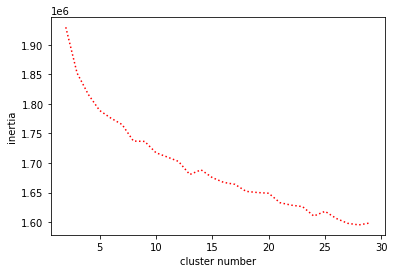

In [12]:
plt.figure()
plt.xlabel('cluster number')
plt.ylabel('inertia')
plt.plot(list(elbow.keys()), list(elbow.values()), color='red', linestyle='dotted')
plt.show()

In order to implement our own clustering, we will be using nested lists.

In [13]:
word_vector1 = []

for idx in range(len(df_adjectives)):
    list_w1 = list(df_adjectives.iloc[idx])
    word_vector1.append(list_w1)

In this next section, we execute two k-means algorithms. The first one is our own algorithm with random initialization, while the second is the one provided from sk-learn with k++ initialization.

### Our k-means implementation

In [14]:
my_clusters = mod.cluster_labels(word_vector1,30,14)

print(my_clusters[0:1000])

cluster labels for iteration 0 for the first 100 items are [12, 4, 4, 4, 1, 10, 1, 4, 4, 4, 12, 4, 4, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 4, 4, 4, 1, 1, 12, 13, 1, 1, 1, 4, 1, 4, 4, 13, 9, 1, 10, 1, 12, 4, 4, 4, 4, 4, 4, 4, 12, 12, 4, 7, 4, 4, 3, 3, 10, 4, 4, 4, 12, 10, 4, 10, 4, 4, 4, 13, 7, 1, 6, 4, 10, 4, 4, 1, 4, 4, 1, 3, 4, 4, 12, 9, 4, 4, 1, 4, 1, 3, 4, 4, 4, 9, 4, 4, 4]
cluster labels for iteration 1 for the first 100 items are [0, 4, 4, 4, 1, 10, 1, 4, 4, 4, 12, 4, 4, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 4, 4, 4, 1, 1, 12, 13, 1, 1, 1, 4, 1, 4, 4, 13, 11, 1, 2, 1, 12, 4, 4, 4, 4, 4, 4, 4, 12, 12, 4, 7, 4, 4, 3, 3, 10, 4, 4, 4, 1, 10, 4, 10, 4, 4, 4, 13, 7, 1, 6, 4, 10, 4, 8, 1, 4, 4, 1, 2, 4, 4, 12, 11, 4, 4, 3, 4, 1, 3, 4, 4, 4, 9, 4, 4, 4]
cluster labels for iteration 2 for the first 100 items are [12, 4, 4, 4, 1, 10, 1, 4, 4, 4, 12, 4, 4, 4, 4, 4, 4, 4, 4, 4, 10, 4, 4, 4, 4, 4, 4, 1, 1, 12, 13, 1, 1, 1, 4, 1, 4, 4, 13, 11, 1, 2, 1, 12, 4, 4, 4, 4, 4, 4, 4, 12, 12, 4, 7, 4, 4, 3, 

cluster labels for iteration 22 for the first 100 items are [13, 4, 4, 13, 1, 10, 1, 13, 4, 13, 12, 4, 4, 13, 4, 4, 13, 4, 5, 4, 10, 4, 4, 4, 4, 4, 4, 1, 0, 12, 2, 1, 1, 1, 13, 1, 4, 2, 13, 11, 1, 2, 1, 12, 13, 0, 13, 13, 4, 4, 13, 12, 12, 0, 5, 0, 0, 3, 3, 10, 13, 13, 4, 1, 4, 4, 10, 4, 13, 4, 2, 2, 1, 6, 4, 4, 13, 8, 1, 13, 2, 0, 12, 4, 4, 12, 11, 4, 8, 3, 4, 1, 3, 2, 4, 4, 8, 4, 4, 4]
cluster labels for iteration 23 for the first 100 items are [13, 4, 4, 13, 1, 10, 1, 13, 4, 13, 12, 4, 4, 13, 4, 4, 13, 4, 5, 4, 10, 4, 4, 4, 4, 4, 4, 1, 0, 12, 2, 1, 1, 1, 13, 1, 4, 2, 13, 11, 1, 2, 1, 12, 13, 0, 13, 13, 4, 4, 13, 12, 12, 0, 5, 0, 0, 3, 3, 10, 13, 13, 4, 1, 4, 4, 10, 4, 13, 4, 2, 2, 1, 6, 4, 4, 13, 8, 1, 13, 2, 0, 12, 4, 4, 12, 11, 4, 8, 3, 4, 1, 3, 2, 4, 4, 8, 4, 4, 4]
cluster labels for iteration 24 for the first 100 items are [13, 4, 4, 13, 1, 10, 1, 13, 4, 13, 12, 4, 4, 13, 4, 4, 13, 4, 5, 4, 10, 4, 4, 4, 4, 4, 4, 1, 0, 12, 2, 1, 1, 1, 13, 1, 4, 2, 13, 11, 1, 2, 1, 12, 13, 0, 13, 

### Bonus Question #2

As per our assignment bonus question, from the output above we can easily observe how, during the clustering evolution process, each label gets updated after every iteration.

### Sklearn with k++ initialization results

In [15]:
kmeans = KMeans(n_clusters=14,init='k-means++', max_iter=30, verbose=False).fit(df_adjectives)
clusters = kmeans.labels_

print(clusters[0:100])

[ 7  9  9  7  8  3  8  7  9 12  9  9  1  7  9  9  7  9  9  9  9  9  9  9
  9  9  9  8  8  9  2  8  5  5  7  8  9 13  7 10  5  0 12  7  7 13  7  7
 11 12  7 11  9  0  6  0  0  8  8  9  7  7  9  8  9  9 13  4  7  4  2  2
  5  2  9  9  7  1  8  7 13  8  2  9  1  8 10 11  9  5  1  8  5 13  9  1
 10  9  9  9]


After this step, we add the cluster values for both algorithms to our initial dataset.

In [16]:
df1["own_cluster"] = my_clusters
df1["sklearn_cluster_k++"] = clusters

df1.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Datetime,taken_words,adjectives,own_cluster,sklearn_cluster_k++
Id,,,,,,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,"[bought, several, vitality, canned, dog, food,...","[several, dog, good, finicky]",13,7
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,"[product, arrived, labeled, jumbo, salted, pea...","[labeled, peanut, small, unsalted, sure, repre...",4,9
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,"[confection, around, century, light, pillowy, ...","[nut, filbert, tiny, powdered, tiny, mouthful,...",4,9
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,"[looking, secret, ingredient, robitussin, beli...","[secret, good]",13,7
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,"[great, taffy, great, price, wide, assortment,...","[great, taffy, great, wide, quick]",1,8


We now move to making some comments about the differences in results obtained from our clustering implementation and the sklearn implementation. We visualize these differences through histograms, to make them easier to see.

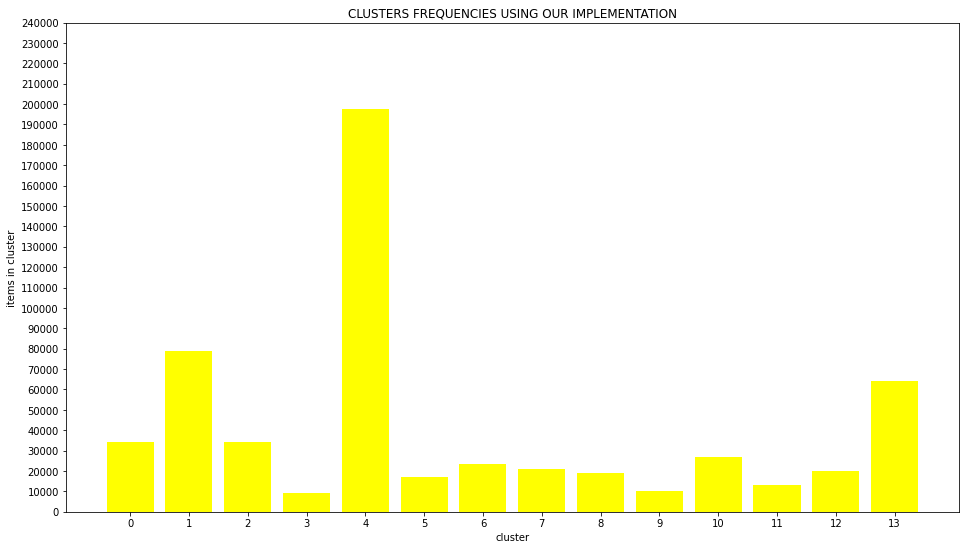

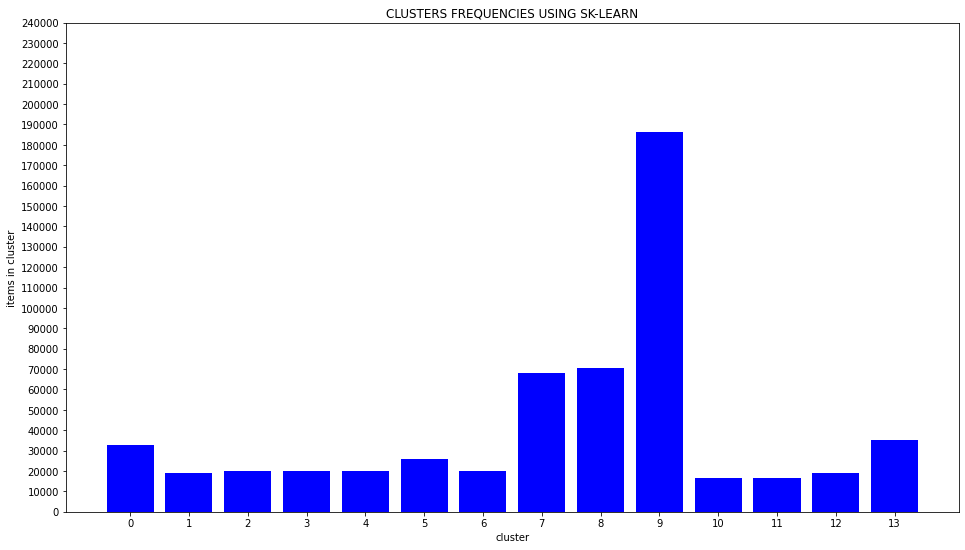

In [45]:
clusters = pd.Series(clusters).value_counts().sort_values().to_dict()
my_clusters = pd.Series(my_clusters).value_counts().sort_values().to_dict()

plt.figure(figsize=(16,9))
plt.title("clusters frequencies using our implementation".upper())
plt.bar(my_clusters.keys(),my_clusters.values(),color='yellow')
plt.xticks(np.arange(0,14,1))
plt.yticks(np.arange(0,250000,10000))
plt.xlabel("cluster")
plt.ylabel('items in cluster')
plt.show()

plt.figure(figsize=(16,9))
plt.title('clusters frequencies using sk-learn'.upper())
plt.bar(clusters.keys(),clusters.values(), color='blue')
plt.xticks(np.arange(0,14,1))
plt.yticks(np.arange(0,250000,10000))
plt.xlabel("cluster")
plt.ylabel('items in cluster')
plt.show()

From the histograms above it is possible to observe the number of reviews contained in each cluster. Please note that the cluster labels among the two implementations do not correspond, since the center initialization changes every time the script is executed.

Regardless of labels, it can be noticed how a major cluster containing a high number of reviews is found in both graphs. Moreover, there are two middle clusters in both implementation, although they present a slight difference in number of reviews. Lastly, there are many clusters with significantly less reviews in both implementations.

### Cluster analysis

After this, we provide the number of products found in each cluster and show the results in a pie chart.

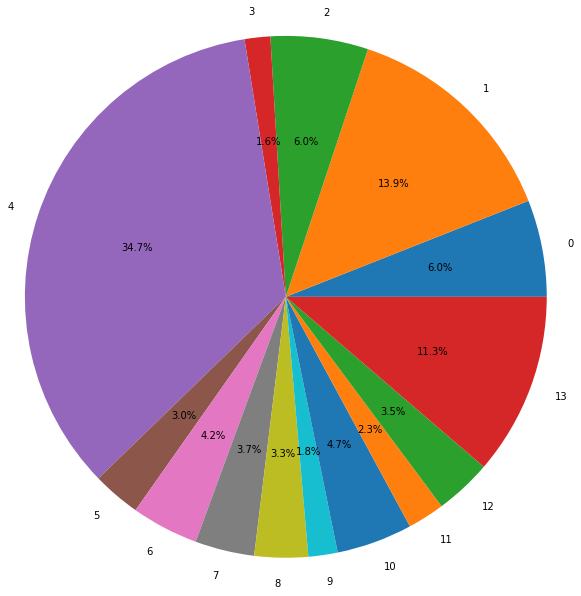

In [48]:
df_count = df1.groupby(["own_cluster"]).count()
df_count = df_count.ProductId

plt.pie(df_count,labels=df_count.index,radius=3,autopct='%1.1f%%')
plt.show()

In addition, the score distribution for each cluster is shown in the following plots.

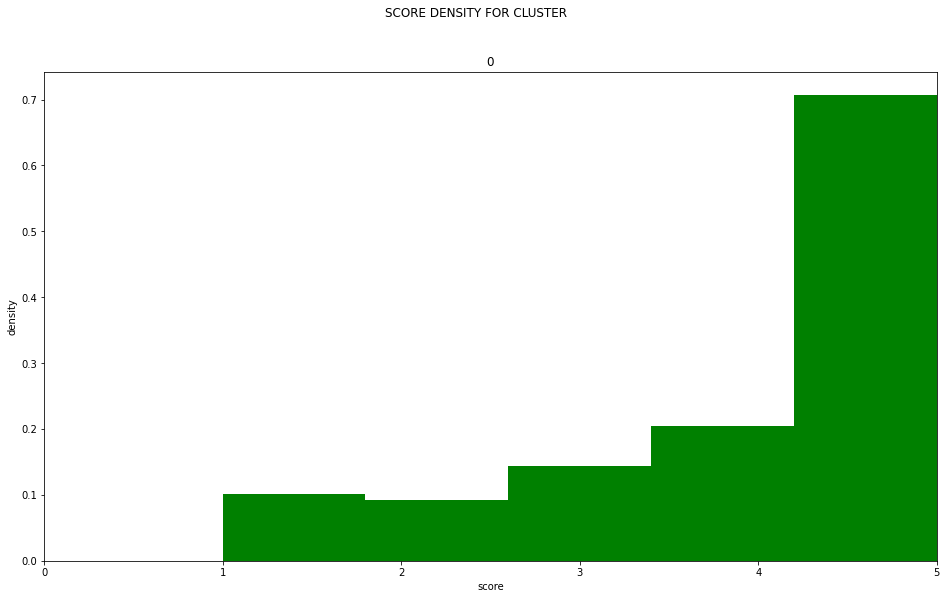

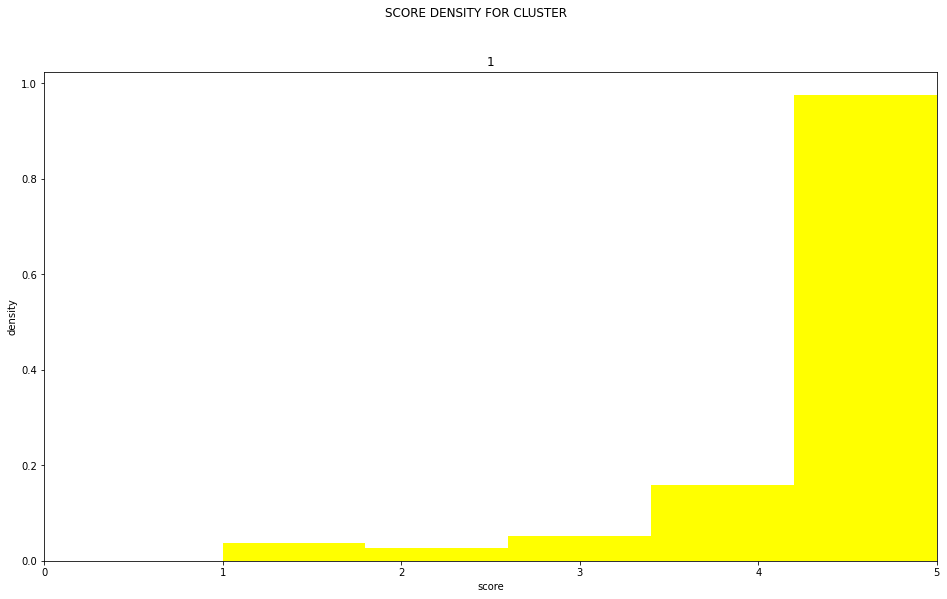

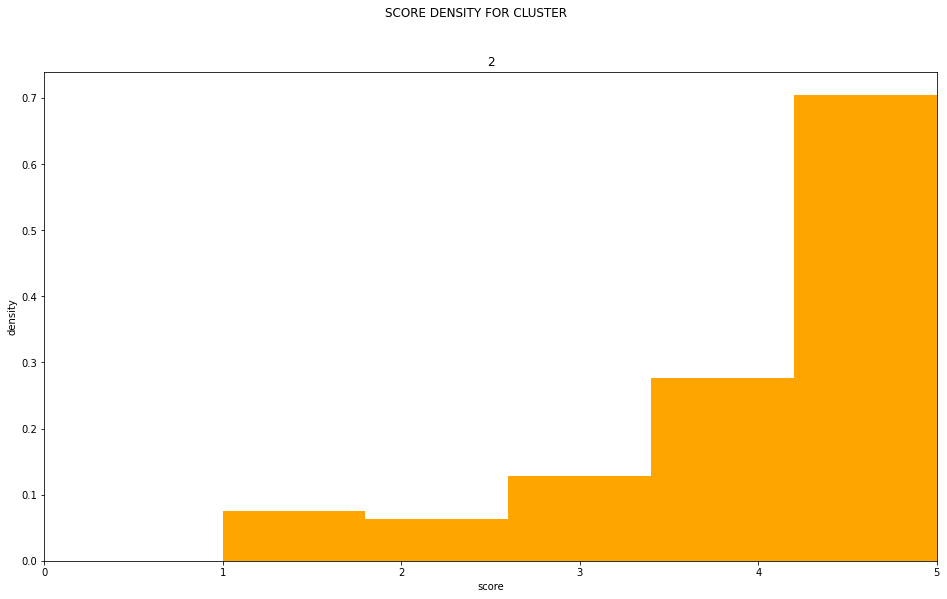

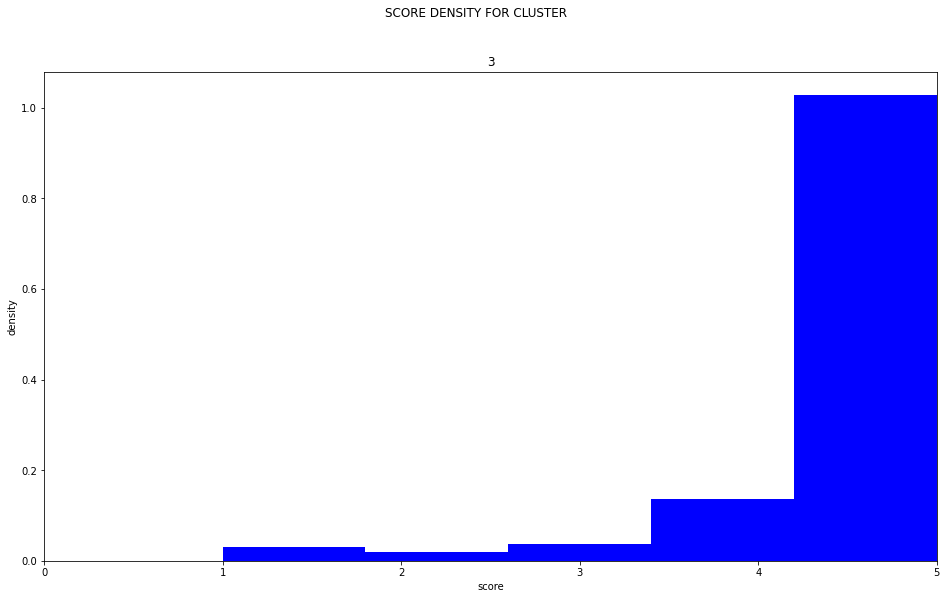

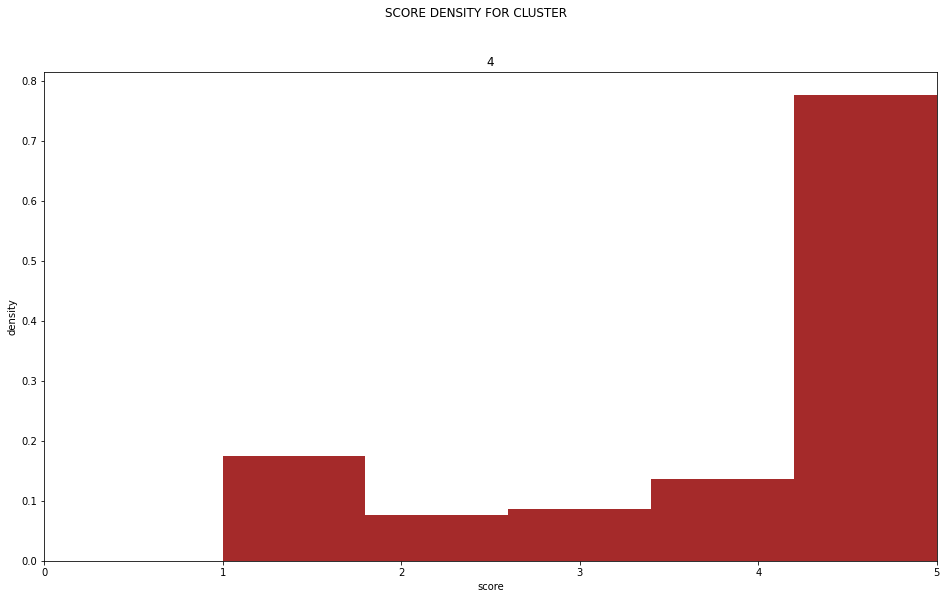

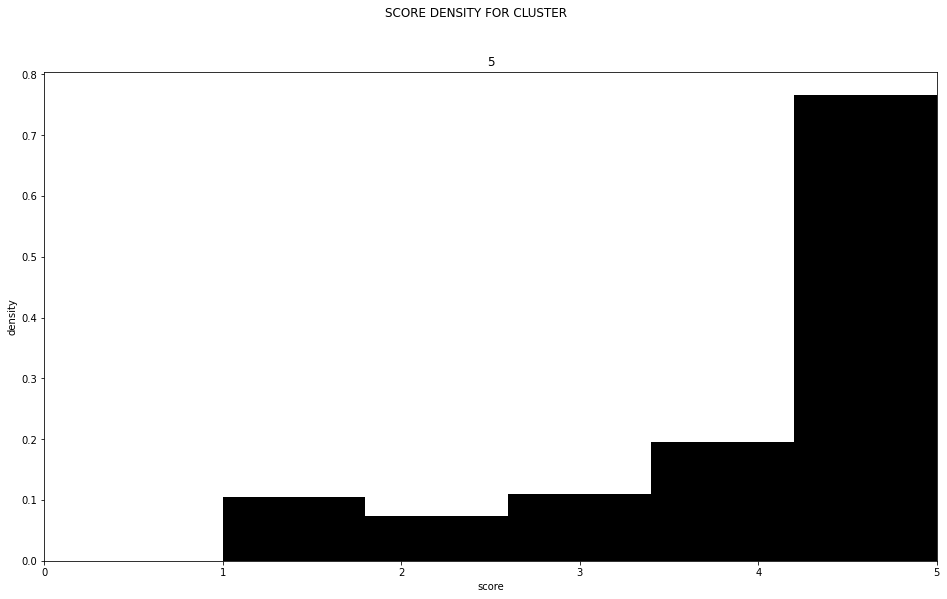

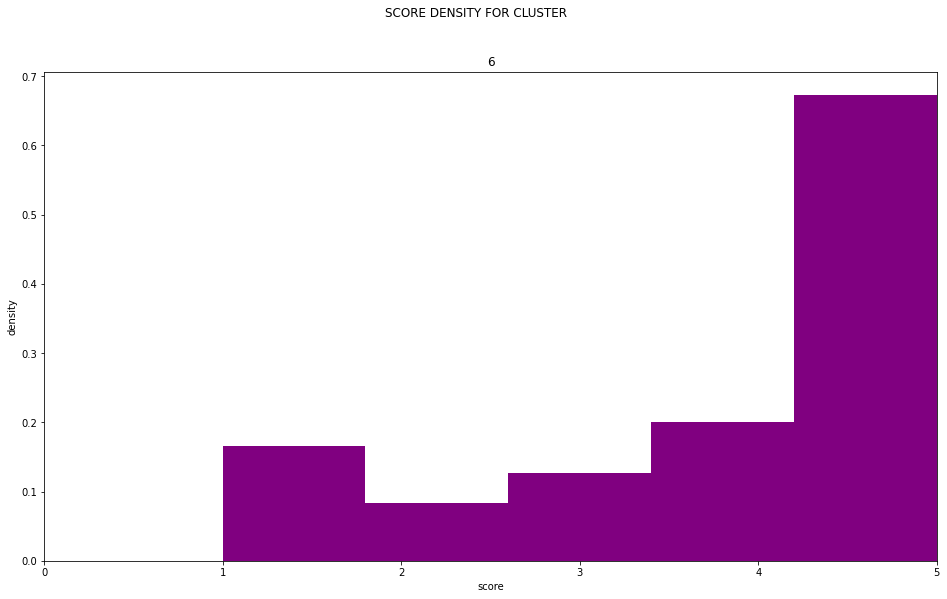

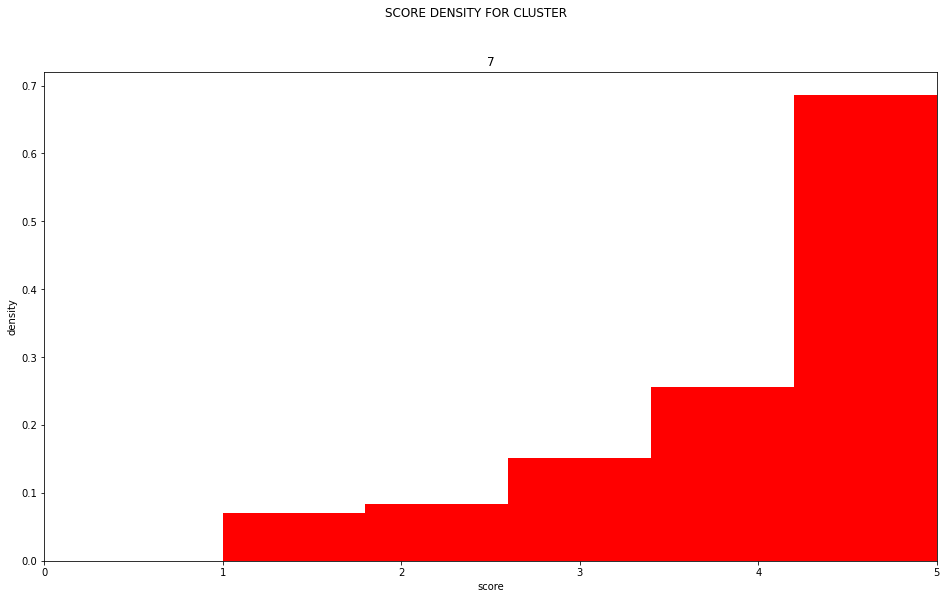

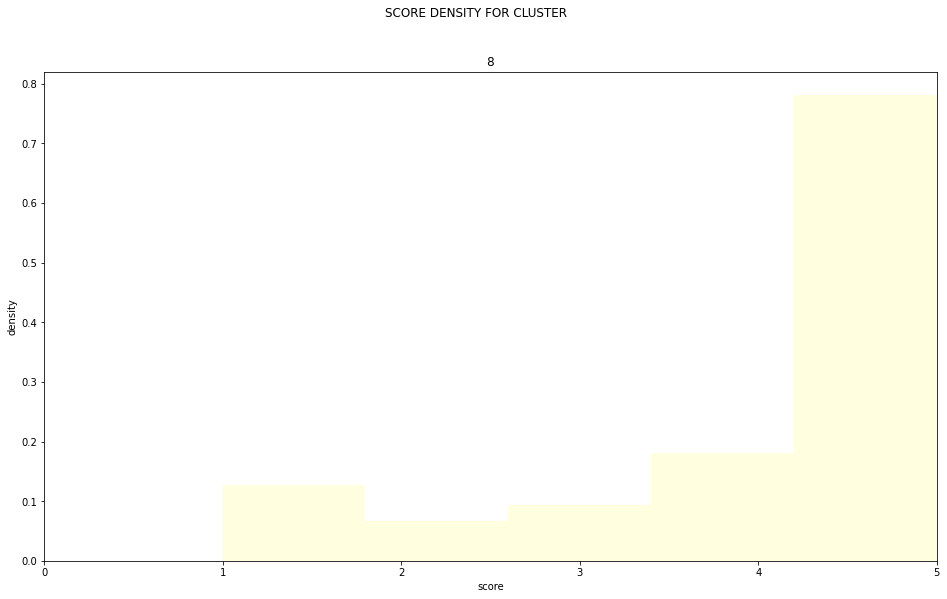

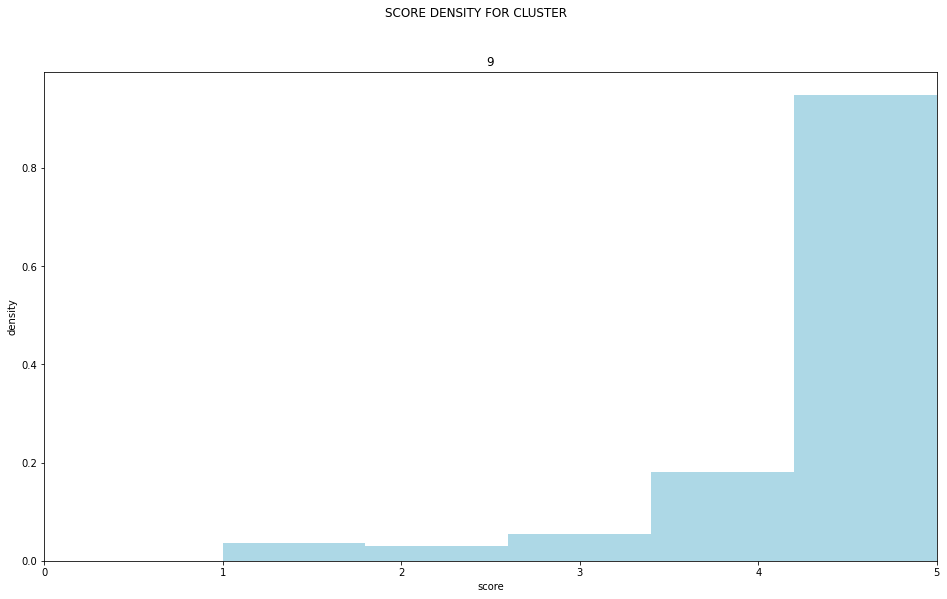

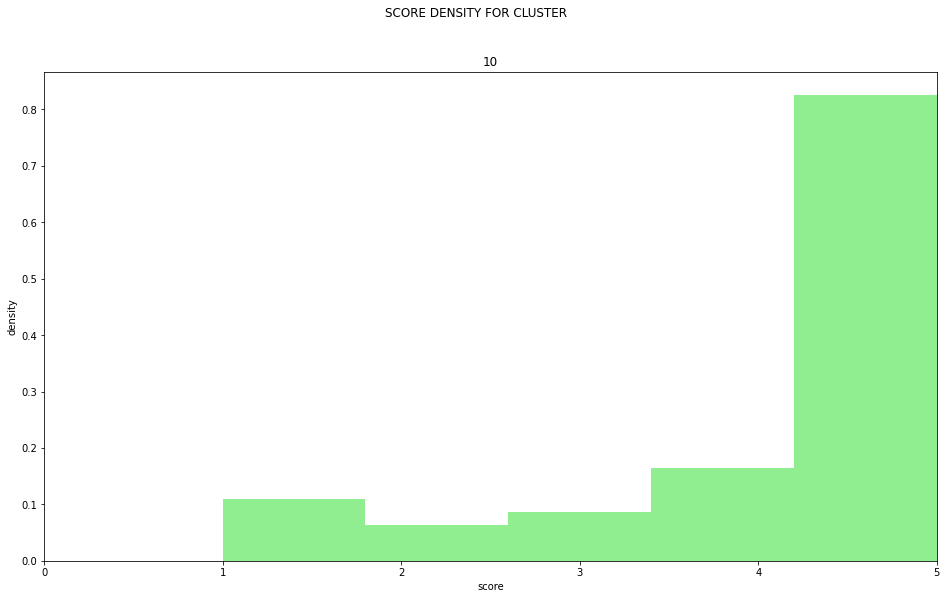

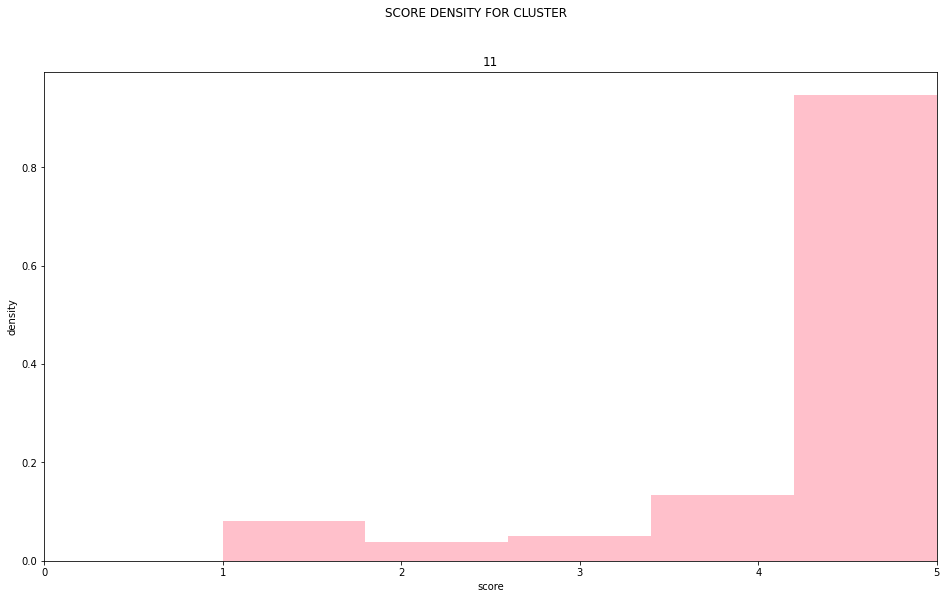

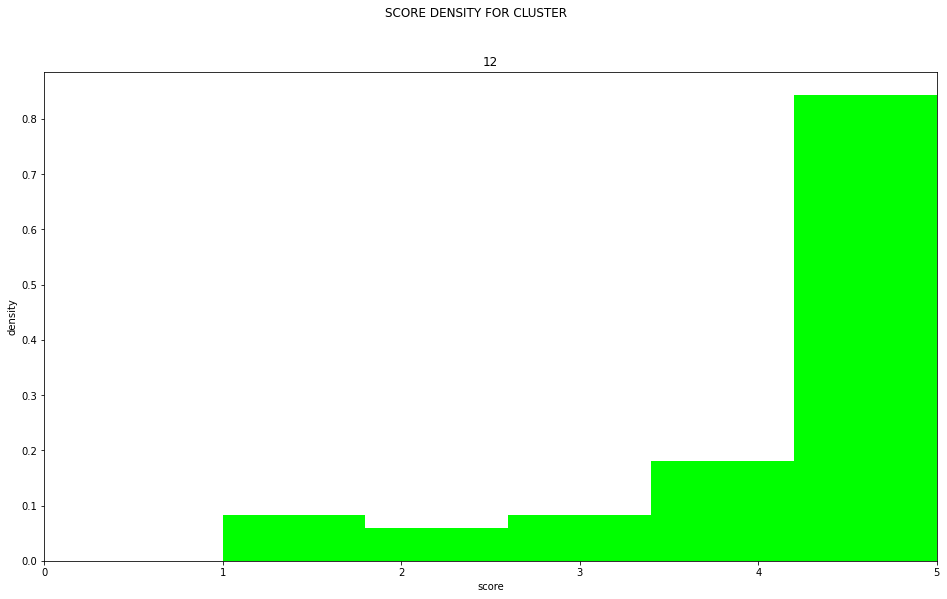

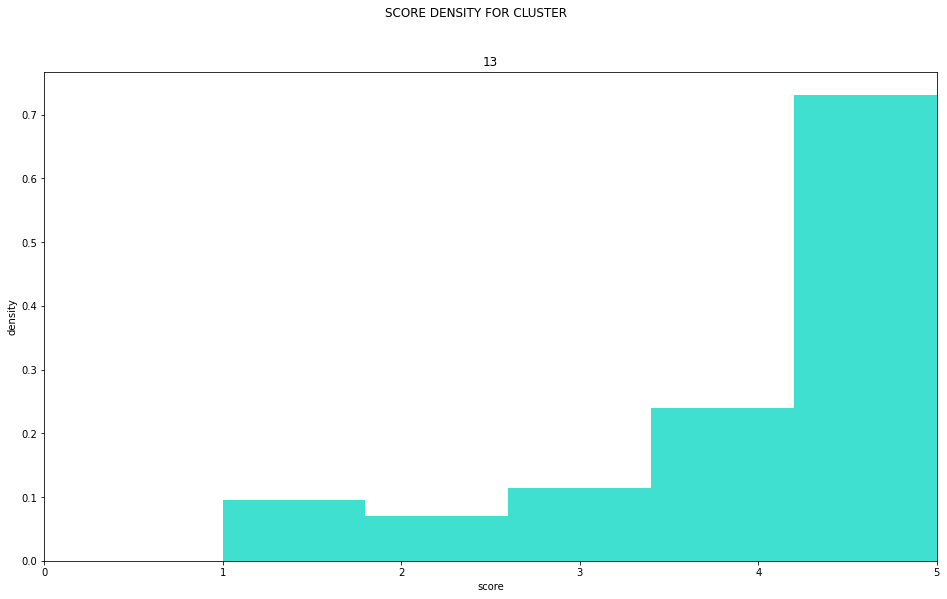

In [49]:
score = mod.score_distribution(df1,14)

In [52]:
from scipy.stats import ttest_ind_from_stats as ttest

means = list(score[0].values())
stds = list(score[1].values())
mean_dataset = np.mean(df1.Score)
std_dataset = np.std(df1.Score)

In [53]:
# MEAN DIFFERENCE SIGNIFICANCY AMONG THE SCORES OF ALL DATASET AND THE SCORES OF EACH CLUSTER

mod.mean_difference_main(0.05,means,stds,df1,df_count)

,t,p-value,significant
0,-17.105545,1.398447e-65,True
1,87.892931,0.000000e+00,True
2,-0.897194,3.696159e-01,False
3,36.698090,1.717685e-294,True
4,-48.545560,0.000000e+00,True
5,-2.670906,7.564884e-03,True
6,-31.860888,1.437805e-222,True
7,-6.589093,4.428928e-11,True
8,-4.651706,3.292712e-06,True
9,30.572143,4.190460e-205,True


In [54]:
# MEAN DIFFERENCE AMONG ALL THE COMBINATIONS(n=14,k=2) OF CLUSTERS

mod.mean_difference(0.05,means,stds,df_count)

,t,p-value,significant
0,-81.396246,0.000000e+00,True
1,-12.465104,1.265158e-35,True
2,-43.855168,0.000000e+00,True
3,5.508932,3.614001e-08,True
4,-7.990794,1.368601e-15,True
...,...,...,...
86,-7.642870,2.164723e-14,True
87,7.801642,6.175282e-15,True
88,11.043191,2.650205e-28,True
89,25.935536,1.141302e-147,True


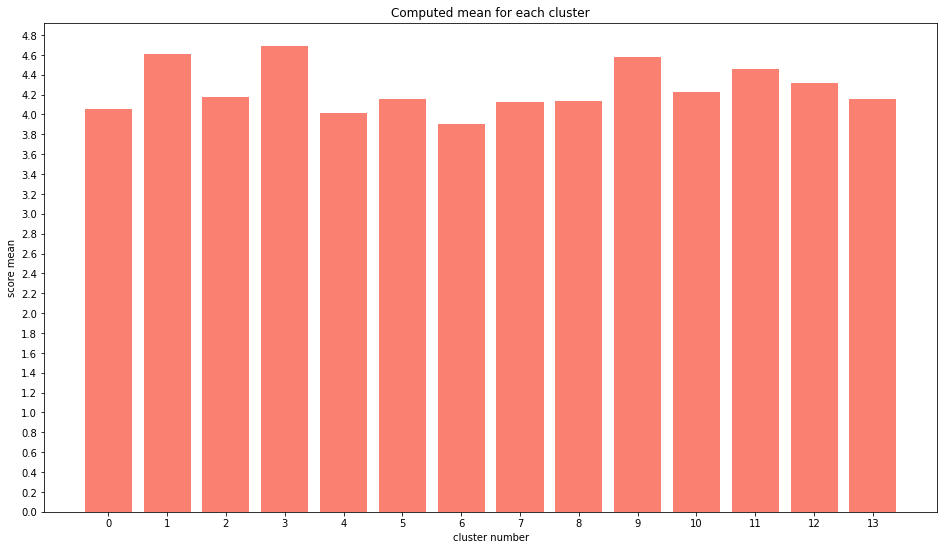

In [66]:
plt.figure(figsize=(16,9))
plt.bar([x for x in range(14)],means,color='salmon')
plt.xlabel("cluster number")
plt.xticks(np.arange(0,14,1))
plt.yticks(np.arange(0,5,0.2))
plt.ylabel('score mean')
plt.title("Computed mean for each cluster")
plt.show()

Lastly, we get the number of unique users writing reviews in each cluster.

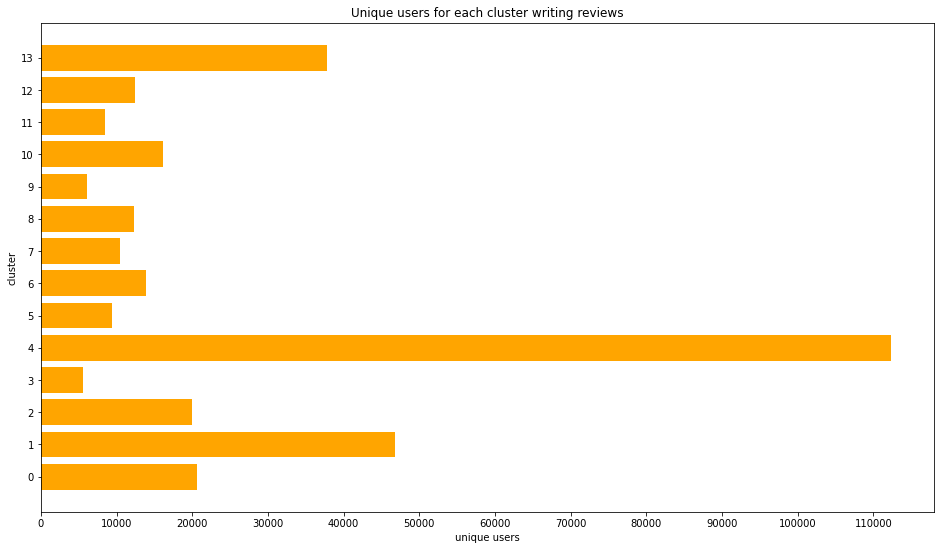

In [72]:
# Get the number of unique users writing reviews in each cluster

uniques = mod.unique_users(df1, 14)

plt.figure(figsize=(16,9))
plt.title('Unique users for each cluster writing reviews')
plt.barh(uniques.index, uniques, color='orange')
plt.yticks(np.arange(0,14,1))
plt.xticks(np.arange(0,120000,10000))
plt.xlabel('unique users')
plt.ylabel('cluster')
plt.show()

### WordCloud

Finally, we visualize our findings through some wordclouds, one for each cluster.

In [73]:
from wordcloud import WordCloud as WC

coffee_image = np.array(Image.open('moka.jpg'))
df1.Text

Id
1         I have bought several of the Vitality canned d...
2         Product arrived labeled as Jumbo Salted Peanut...
3         This is a confection that has been around a fe...
4         If you are looking for the secret ingredient i...
5         Great taffy at a great price.  There was a wid...
                                ...                        
568450    Great for sesame chicken..this is a good if no...
568451    I'm disappointed with the flavor. The chocolat...
568452    These stars are small, so you can give 10-15 o...
568453    These are the BEST treats for training and rew...
568454    I am very satisfied ,product is as advertised,...
Name: Text, Length: 568454, dtype: object

In [74]:
food_list = ['tea','coffee','chocolate','water','cocoa','sauce','juice','ice cream','cake','butter','bread','milk','pizza','pasta','eggs','cookies','meat','soup','ramen','noodles','beans','popcorn','corn','broccoli','tuna','salmon','bacon','coke','onion','nuggets','potatoes','salt','pepper','sugar','almonds','nuts','peanuts','flour','rice','wine','beer','chicken','pork']
names_list = df1["taken_words"].apply(lambda wordlist_1: mod.take_names(wordlist_1))
flat_list_nn = [item for sublist in names_list for item in sublist]
nouns_list = pd.Series(flat_list_nn).value_counts().index

nouns_list

Index(['taste', 'product', 'flavor', 'coffee', 'food', 'tea', 'time', 'dog',
       'price', 'bag',
       ...
       'stck', 'machu', 'sxpiry', 'cupella', 'buscas', 'vpi', 'withing',
       'piave', 'tavie', 'korn'],
      dtype='object', length=55340)

**First word cloud**

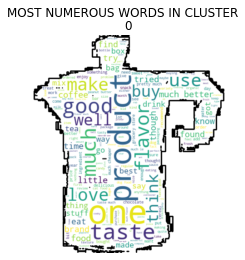

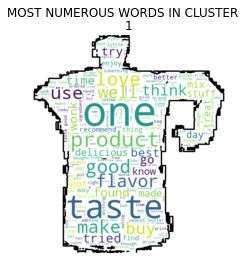

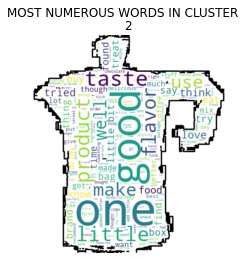

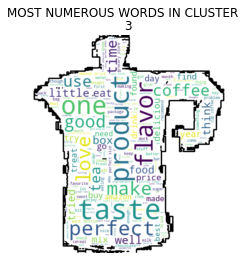

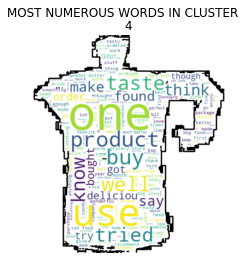

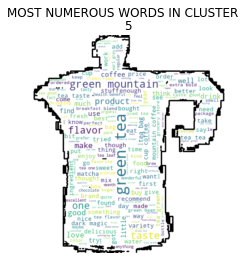

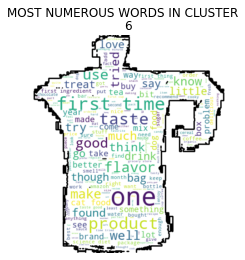

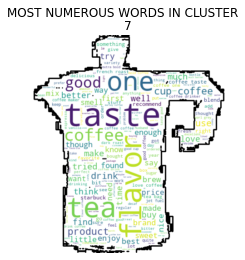

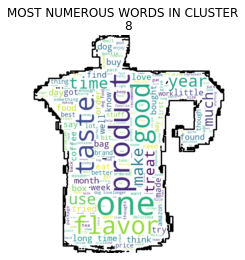

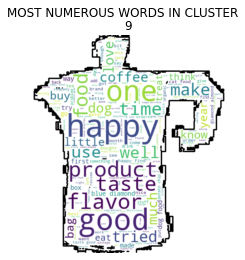

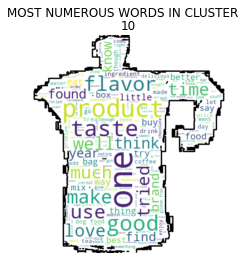

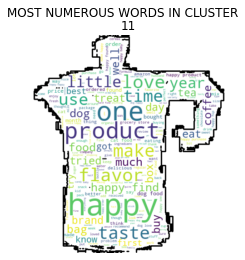

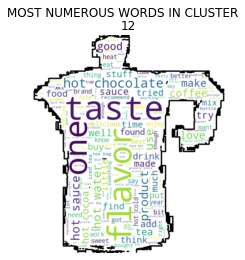

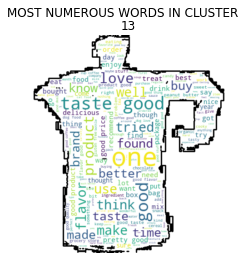

In [75]:
mod.word_cloud(coffee_image,df1,14,nouns_list)

**Second word cloud**

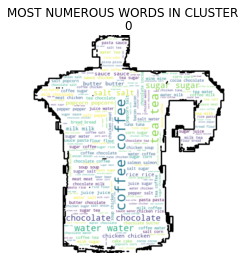

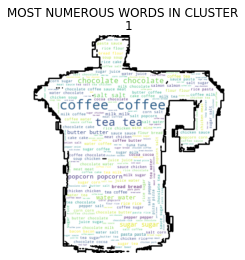

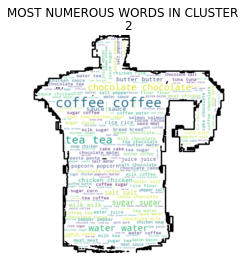

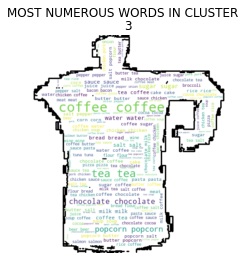

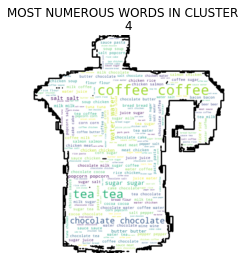

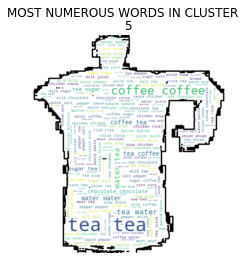

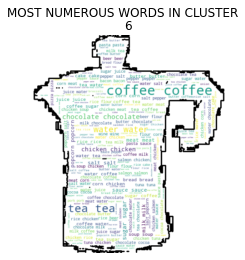

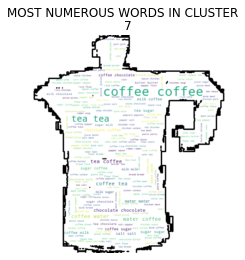

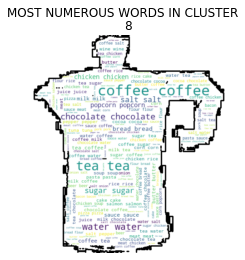

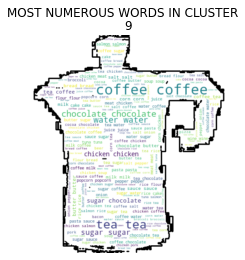

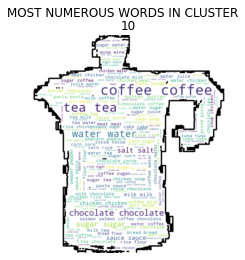

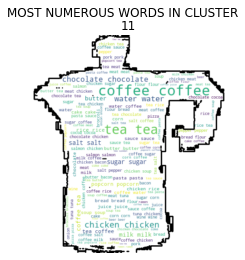

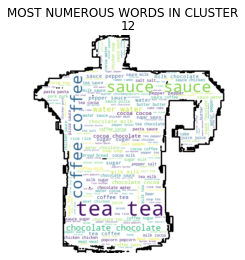

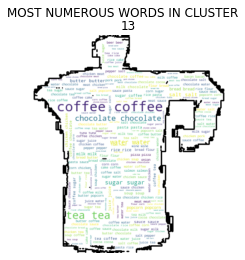

In [76]:
mod.word_cloud(coffee_image,df1,14,food_list)

**Third word cloud**

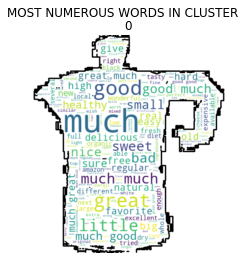

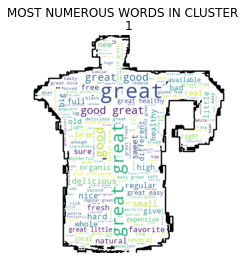

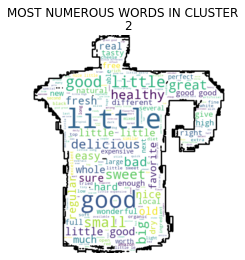

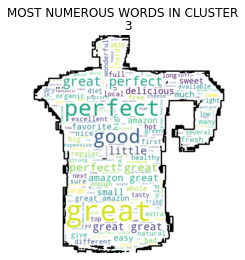

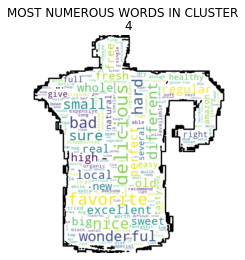

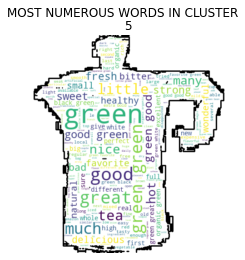

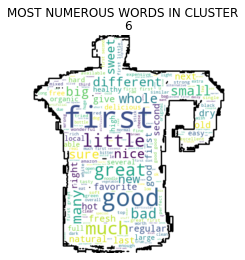

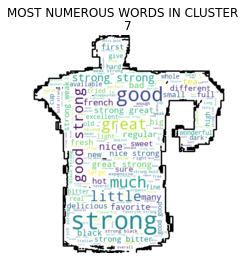

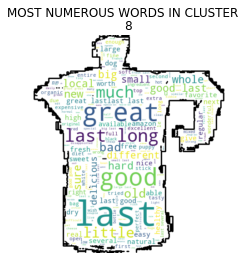

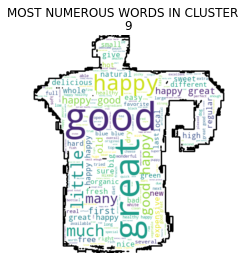

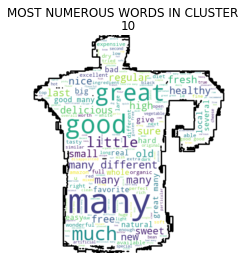

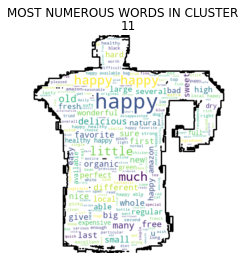

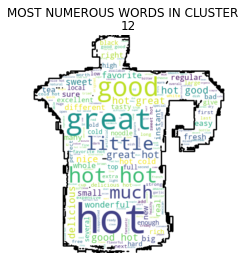

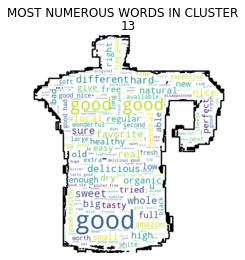

In [77]:
mod.word_cloud_1(coffee_image,df1,14,all_adjectives)

## Question 3

### Algohritmic question

A perfect fit for the given hypothesis could be the Counting Sort algorhitm, which is a well known method for sorting arrays.

Sorting an array using the Counting Sort algorithm requires that the range of the values of the array of interest, meaning the difference between its maximum and its minimum, be given or calculated before the implementation of the algorithm itself. This algorithm involves three steps.

Firstly, the frequency of each element of the array is computed and then stored in an accompanying counting array. This is where the algorithm gets its name from.

The subsequent step consists in iterating over this counting array and incrementing its values so that each element comprises the sum of the preceding ones. This way the position ranges for each value are established.

At last, the elements of the counting array are returned following the order they are found in in the ranges of the counting array itself.

We provide the pseudo-code for the Counting Sort algohritm in the cell below:

In [19]:
def countingSort(array):
    count = array of k+1 zeros

    for x in input:
       count[key(x)]+=1

    total=0

    for i in 0,1,.... k:
       count[i], total = total, count[i] + total

    output = array which has the same lenght of the input

    for x in input:
        output[count[key(x))]] = x
        count[key(x)] +=1

    return output

It is a non-comparison sorting algorithm, since the values are not compared to each other. Because of this, the complexity of this algorithm is not limited by ${\mathcal{O}(n\log n)}$.
It is actually easy to see that, being r the range and n the number of elements in the input array, the complexity of this algorithm is simply the sum of the two. In fact, the complexity of each step is clearly stated in the for loop preceding it:

Step 1: for x in input $ \rightarrow {\mathcal{O}(n)}$ <br>
Step 2: for i in 0,1,...,r $ \rightarrow {\mathcal{O}(r)}$ <br>
Step 3: for x in input $ \rightarrow {\mathcal{O}(n)}$ <br>

Therefore, the final complexity is: <br>
${\mathcal{O}(n) + \mathcal{O}(r) + \mathcal{O}(n) = \mathcal{O}(n) + \mathcal{O}(r) = \mathcal{O}(n+r)}$ 

It should be noted that some other algorithms, such as Bucket Sort, can also have this same complexity, but usually it is only a best case scenario. Counting Sort is the only algorithm that consistently has this complexity.